In [2]:
import numpy as np, os, sys

import matplotlib.pyplot as plt #patch-wise similarities, droi images
from matplotlib import ticker, cm

import torch.nn as nn
import torch.utils.data 

from torchvision import datasets, transforms
import torch.optim

In [2]:
class FashionNet(nn.Module):
    def __init__(self, batch_size, val_size, tr_size):
        # linear1, linear2 and linear3 follow l1, l2, and l3 respectively
        
        super(FashionNet, self).__init__()
        self.linear1 = nn.Linear(28*28, 300) # l1 -> input of 28 * 28 follows the tensor shape of FashionMNIST
        self.linear2 = nn.Linear(300, 100) # l2
        self.linear3 = nn.Linear(100, 10) # l3
        self.batch_size = batch_size
        self.val_size = val_size
        self.tr_size = tr_size
        
    def forward(self, x):
        
        # Need to reshape as the input is 2800 x 28, so we reshape into 100 x 28 x 28
        x = torch.reshape(x,(-1,28*28))
        
        # First layer and first relu
        first_out = self.linear1(x)
        first_relu_out = torch.relu_(first_out)
        
        # Second hidden layer
        second_out = self.linear2(first_relu_out)
        second_relu_out = torch.relu_(second_out)
        
        # Y predictions
        y_pred = self.linear3(second_relu_out)
        
        return y_pred

In [3]:
def train_epoch(lr, model, trainloader, criterion, device, optimizer):
    model.train()
 
    losses = list()
    for batch_idx, data in enumerate(trainloader):

        inputs=data[0].to(device)
        labels=data[1].to(device)
        optimizer.zero_grad()
        
        output = model(inputs)
        
        loss = criterion(output, labels)
        loss.backward()
        
        optimizer.step()
        losses.append(loss.item())

    return losses

In [4]:
def evaluate(model, dataloader, criterion, device, is_test=False, is_train=False):

    model.eval()

    gtpos=0
    gtneg=0
    tps=0
    tns=0
    fbeta=1

    running_corrects = 0
    
    # Check if using traing, val or test datasets
    if is_test:
        data_size = len(dataloader.dataset)
    elif is_train:
        data_size = model.tr_size
    else:
        data_size = model.val_size
    
    # Store val or test losses
    val_test_losses = list()
    
    with torch.no_grad():
        for ctr, data in enumerate(dataloader):

            print ('epoch at',len(dataloader.dataset), ctr)
            inputs = data[0].to(device)        
            outputs = model(inputs)

            labels = data[1]
            
            # Calculate val/test loss
            val_test_loss = criterion(outputs, labels)
            val_test_losses.append(val_test_loss.item())
            
            labels = labels.float()
            cpuout= outputs.to('cpu')

            _, preds = torch.max(cpuout, 1)


            running_corrects += torch.sum(preds == labels.data)            
            accuracy = running_corrects.double() / data_size 

    return accuracy.item(), val_test_losses

In [5]:
def train_modelcv(lr, dataloader_cvtrain, dataloader_cvtest ,  model ,  criterion, optimizer, scheduler, num_epochs, device):

    best_measure = 0
    best_epoch =-1

    # Stores the averaged loss over all minibatches for each epoch
    tr_averaged_loss = []
    val_tes_averaged_loss = []
    val_tes_accuracies = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        model.train(True)
        losses=train_epoch(lr, model,  dataloader_cvtrain,  criterion,  device , optimizer)
        
        # Append to training average loss
        tr_averaged_loss.append(np.average(losses))
        
        #scheduler.step()

        model.train(False)
        measure, val_test_losses = evaluate(model, dataloader_cvtest, criterion, device)
        print(' perfmeasure', measure)
        
        # Append to val_accuracies
        val_tes_accuracies.append(measure)
        
        # Append to val_test average loss
        val_tes_averaged_loss.append(np.average(val_test_losses))
        
        # Store the weight
        torch.save(model.state_dict(), f'epoch_checkpoints/epoch_{epoch}_model.ckpt')
        
        if measure > best_measure: #higher is better or lower is better?
            bestweights= model.state_dict()
            best_measure = measure
            best_epoch = epoch
            print('current best', measure, ' at epoch ', best_epoch)

    return best_epoch, best_measure, bestweights, tr_averaged_loss, val_tes_averaged_loss, val_tes_accuracies


In [6]:
def plot_it(tr_acc, val_acc, test_acc, tr_loss, val_loss, test_loss):
    
    plt.figure(figsize=(20,5))
    plt.subplot(121),
    plt.plot(tr_acc, label = "Training Accuracy"),
    plt.plot(val_acc, label = "Validation Accuracy"),
    plt.plot(test_acc, label = "Test Accuracy"),
    plt.title('Accuracy')
    plt.subplot(122),
    plt.plot(tr_loss, label = "Training Loss"),
    plt.plot(val_loss, label = "Validation Loss"),
    plt.plot(test_loss, label = "Test Loss"),
    plt.title('Loss')
    plt.legend(frameon = False)
    plt.show()

In [7]:
def run():
    
    maxnumepochs = 5
    validation_size = 0.1
    batch_size = 100
    learning_rate = 0.01

    torch.manual_seed(1) # Set random seed

    # Fetch and download FashionMNIST dataset from torchvision and transform to TensorDataset
    tr_data = datasets.FashionMNIST("FashionMNIST_data", train = True, download = True, transform = transforms.ToTensor())
    tes_data = datasets.FashionMNIST("FashionMNIST_data", train = False, download = True, transform = transforms.ToTensor())


    ### Create a sampler for training and validation dataloaders ###

    # Prepare the index ranges for splitting our train and val first
    num_instances = len(tr_data)
    indexes = list(range(num_instances)) # a list of indexes for the samplers
    t_v_split = int(np.floor(validation_size * num_instances)) # use this to split up our train and val

    tr_indexes = indexes[t_v_split:]
    val_indexes = indexes[:t_v_split]

    # Create the samplers
    tr_sampler = torch.utils.data.sampler.SubsetRandomSampler(tr_indexes)
    val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indexes)

    # Create our dataloaders for training and validation using our samplers
    trloader = torch.utils.data.DataLoader(tr_data, batch_size = batch_size, sampler = tr_sampler)
    valloader = torch.utils.data.DataLoader(tr_data, batch_size = batch_size, sampler = val_sampler)


    # Initialize Model
    model = FashionNet(batch_size, t_v_split, num_instances)

    # Initialize Loss Function, in this case we use cross entropy for 10 classes 
    criterion = nn.CrossEntropyLoss()

    # Initialize optimizer SGD
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.0, weight_decay = 0)

    # Set up device
    use_cuda = torch.cuda.is_available()
    # device = torch.device("cuda" if use_cuda else "cpu")
    device = torch.device('cpu')


    best_epoch, best_perfmeasure, bestweights, train_averaged_loss, val_averaged_loss, val_accuracies = train_modelcv(lr = learning_rate, dataloader_cvtrain = trloader, dataloader_cvtest = valloader ,  model = model ,  criterion = criterion , optimizer = optimizer, scheduler = None, num_epochs = maxnumepochs , device = device)

    ## Create test dataloader
    tesloader = torch.utils.data.DataLoader(tes_data, batch_size = 100, shuffle = False)

    # We loop through the different weights from each epoch to get the test losses
    test_averaged_loss = []
    test_accuracies = []

    train_accuracies = []

    for i in range(maxnumepochs):
        # Load the weights
        model.load_state_dict(torch.load(f'epoch_checkpoints/epoch_{i}_model.ckpt'))

        # Test
        test_accuracy, test_loss = evaluate(model = model, dataloader = tesloader, criterion = criterion, device = device, is_test = True)

        test_averaged_loss.append(np.average(test_loss))
        test_accuracies.append(test_accuracy)

        # Train
        train_accuracy, _ = evaluate(model = model, dataloader = trloader, criterion = criterion, device = device, is_train = True)

        train_accuracies.append(train_accuracy)

        
    # Plot 
    plot_it(train_accuracies, val_accuracies, test_accuracies, train_averaged_loss, val_averaged_loss, test_averaged_loss)




94.3%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100.0%

Extracting FashionMNIST_data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to FashionMNIST_data\FashionMNIST\raw


159.1%

Extracting FashionMNIST_data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to FashionMNIST_data\FashionMNIST\raw
Processing...
Done!
Epoch 0/4
----------
epoch at 60000 0
epoch at 60000 1
epoch at 60000 2
epoch at 60000 3
epoch at 60000 4
epoch at 60000 5
epoch at 60000 6
epoch at 60000 7
epoch at 60000 8
epoch at 60000 9
epoch at 60000 10
epoch at 60000 11
epoch at 60000 12
epoch at 60000 13
epoch at 60000 14
epoch at 60000 15
epoch at 60000 16
epoch at 60000 17
epoch at 60000 18
epoch at 60000 19
epoch at 60000 20
epoch at 60000 21
epoch at 60000 22
epoch at 60000 23
epoch at 60000 24
epoch at 60000 25
epoch at 60000 26
epoch at 60000 27
epoch at 60000 28
epoch at 60000 29
epoch at 60000 30
epoch at 60000 31
epoch at 60000 32
epoch at 60000 33
epoch at 60000 34
epoch at 60000 35
epoch at 60000 36
epoch at 60000 37
epoch at 60000 38
epoch at 60000 39
epoch at 60000 40
epoch at 60000 41
epoch at 60000 42
epoch at 60000 43
epoch at 60000 44
epoch at 60000 45
epoch at 60000 46
epoch at 6000

epoch at 60000 35
epoch at 60000 36
epoch at 60000 37
epoch at 60000 38
epoch at 60000 39
epoch at 60000 40
epoch at 60000 41
epoch at 60000 42
epoch at 60000 43
epoch at 60000 44
epoch at 60000 45
epoch at 60000 46
epoch at 60000 47
epoch at 60000 48
epoch at 60000 49
epoch at 60000 50
epoch at 60000 51
epoch at 60000 52
epoch at 60000 53
epoch at 60000 54
epoch at 60000 55
epoch at 60000 56
epoch at 60000 57
epoch at 60000 58
epoch at 60000 59
epoch at 60000 60
epoch at 60000 61
epoch at 60000 62
epoch at 60000 63
epoch at 60000 64
epoch at 60000 65
epoch at 60000 66
epoch at 60000 67
epoch at 60000 68
epoch at 60000 69
epoch at 60000 70
epoch at 60000 71
epoch at 60000 72
epoch at 60000 73
epoch at 60000 74
epoch at 60000 75
epoch at 60000 76
epoch at 60000 77
epoch at 60000 78
epoch at 60000 79
epoch at 60000 80
epoch at 60000 81
epoch at 60000 82
epoch at 60000 83
epoch at 60000 84
epoch at 60000 85
epoch at 60000 86
epoch at 60000 87
epoch at 60000 88
epoch at 60000 89
epoch at 6

epoch at 60000 471
epoch at 60000 472
epoch at 60000 473
epoch at 60000 474
epoch at 60000 475
epoch at 60000 476
epoch at 60000 477
epoch at 60000 478
epoch at 60000 479
epoch at 60000 480
epoch at 60000 481
epoch at 60000 482
epoch at 60000 483
epoch at 60000 484
epoch at 60000 485
epoch at 60000 486
epoch at 60000 487
epoch at 60000 488
epoch at 60000 489
epoch at 60000 490
epoch at 60000 491
epoch at 60000 492
epoch at 60000 493
epoch at 60000 494
epoch at 60000 495
epoch at 60000 496
epoch at 60000 497
epoch at 60000 498
epoch at 60000 499
epoch at 60000 500
epoch at 60000 501
epoch at 60000 502
epoch at 60000 503
epoch at 60000 504
epoch at 60000 505
epoch at 60000 506
epoch at 60000 507
epoch at 60000 508
epoch at 60000 509
epoch at 60000 510
epoch at 60000 511
epoch at 60000 512
epoch at 60000 513
epoch at 60000 514
epoch at 60000 515
epoch at 60000 516
epoch at 60000 517
epoch at 60000 518
epoch at 60000 519
epoch at 60000 520
epoch at 60000 521
epoch at 60000 522
epoch at 600

epoch at 60000 280
epoch at 60000 281
epoch at 60000 282
epoch at 60000 283
epoch at 60000 284
epoch at 60000 285
epoch at 60000 286
epoch at 60000 287
epoch at 60000 288
epoch at 60000 289
epoch at 60000 290
epoch at 60000 291
epoch at 60000 292
epoch at 60000 293
epoch at 60000 294
epoch at 60000 295
epoch at 60000 296
epoch at 60000 297
epoch at 60000 298
epoch at 60000 299
epoch at 60000 300
epoch at 60000 301
epoch at 60000 302
epoch at 60000 303
epoch at 60000 304
epoch at 60000 305
epoch at 60000 306
epoch at 60000 307
epoch at 60000 308
epoch at 60000 309
epoch at 60000 310
epoch at 60000 311
epoch at 60000 312
epoch at 60000 313
epoch at 60000 314
epoch at 60000 315
epoch at 60000 316
epoch at 60000 317
epoch at 60000 318
epoch at 60000 319
epoch at 60000 320
epoch at 60000 321
epoch at 60000 322
epoch at 60000 323
epoch at 60000 324
epoch at 60000 325
epoch at 60000 326
epoch at 60000 327
epoch at 60000 328
epoch at 60000 329
epoch at 60000 330
epoch at 60000 331
epoch at 600

epoch at 60000 92
epoch at 60000 93
epoch at 60000 94
epoch at 60000 95
epoch at 60000 96
epoch at 60000 97
epoch at 60000 98
epoch at 60000 99
epoch at 60000 100
epoch at 60000 101
epoch at 60000 102
epoch at 60000 103
epoch at 60000 104
epoch at 60000 105
epoch at 60000 106
epoch at 60000 107
epoch at 60000 108
epoch at 60000 109
epoch at 60000 110
epoch at 60000 111
epoch at 60000 112
epoch at 60000 113
epoch at 60000 114
epoch at 60000 115
epoch at 60000 116
epoch at 60000 117
epoch at 60000 118
epoch at 60000 119
epoch at 60000 120
epoch at 60000 121
epoch at 60000 122
epoch at 60000 123
epoch at 60000 124
epoch at 60000 125
epoch at 60000 126
epoch at 60000 127
epoch at 60000 128
epoch at 60000 129
epoch at 60000 130
epoch at 60000 131
epoch at 60000 132
epoch at 60000 133
epoch at 60000 134
epoch at 60000 135
epoch at 60000 136
epoch at 60000 137
epoch at 60000 138
epoch at 60000 139
epoch at 60000 140
epoch at 60000 141
epoch at 60000 142
epoch at 60000 143
epoch at 60000 144
e

epoch at 60000 530
epoch at 60000 531
epoch at 60000 532
epoch at 60000 533
epoch at 60000 534
epoch at 60000 535
epoch at 60000 536
epoch at 60000 537
epoch at 60000 538
epoch at 60000 539
epoch at 10000 0
epoch at 10000 1
epoch at 10000 2
epoch at 10000 3
epoch at 10000 4
epoch at 10000 5
epoch at 10000 6
epoch at 10000 7
epoch at 10000 8
epoch at 10000 9
epoch at 10000 10
epoch at 10000 11
epoch at 10000 12
epoch at 10000 13
epoch at 10000 14
epoch at 10000 15
epoch at 10000 16
epoch at 10000 17
epoch at 10000 18
epoch at 10000 19
epoch at 10000 20
epoch at 10000 21
epoch at 10000 22
epoch at 10000 23
epoch at 10000 24
epoch at 10000 25
epoch at 10000 26
epoch at 10000 27
epoch at 10000 28
epoch at 10000 29
epoch at 10000 30
epoch at 10000 31
epoch at 10000 32
epoch at 10000 33
epoch at 10000 34
epoch at 10000 35
epoch at 10000 36
epoch at 10000 37
epoch at 10000 38
epoch at 10000 39
epoch at 10000 40
epoch at 10000 41
epoch at 10000 42
epoch at 10000 43
epoch at 10000 44
epoch at 1

epoch at 60000 343
epoch at 60000 344
epoch at 60000 345
epoch at 60000 346
epoch at 60000 347
epoch at 60000 348
epoch at 60000 349
epoch at 60000 350
epoch at 60000 351
epoch at 60000 352
epoch at 60000 353
epoch at 60000 354
epoch at 60000 355
epoch at 60000 356
epoch at 60000 357
epoch at 60000 358
epoch at 60000 359
epoch at 60000 360
epoch at 60000 361
epoch at 60000 362
epoch at 60000 363
epoch at 60000 364
epoch at 60000 365
epoch at 60000 366
epoch at 60000 367
epoch at 60000 368
epoch at 60000 369
epoch at 60000 370
epoch at 60000 371
epoch at 60000 372
epoch at 60000 373
epoch at 60000 374
epoch at 60000 375
epoch at 60000 376
epoch at 60000 377
epoch at 60000 378
epoch at 60000 379
epoch at 60000 380
epoch at 60000 381
epoch at 60000 382
epoch at 60000 383
epoch at 60000 384
epoch at 60000 385
epoch at 60000 386
epoch at 60000 387
epoch at 60000 388
epoch at 60000 389
epoch at 60000 390
epoch at 60000 391
epoch at 60000 392
epoch at 60000 393
epoch at 60000 394
epoch at 600

epoch at 60000 148
epoch at 60000 149
epoch at 60000 150
epoch at 60000 151
epoch at 60000 152
epoch at 60000 153
epoch at 60000 154
epoch at 60000 155
epoch at 60000 156
epoch at 60000 157
epoch at 60000 158
epoch at 60000 159
epoch at 60000 160
epoch at 60000 161
epoch at 60000 162
epoch at 60000 163
epoch at 60000 164
epoch at 60000 165
epoch at 60000 166
epoch at 60000 167
epoch at 60000 168
epoch at 60000 169
epoch at 60000 170
epoch at 60000 171
epoch at 60000 172
epoch at 60000 173
epoch at 60000 174
epoch at 60000 175
epoch at 60000 176
epoch at 60000 177
epoch at 60000 178
epoch at 60000 179
epoch at 60000 180
epoch at 60000 181
epoch at 60000 182
epoch at 60000 183
epoch at 60000 184
epoch at 60000 185
epoch at 60000 186
epoch at 60000 187
epoch at 60000 188
epoch at 60000 189
epoch at 60000 190
epoch at 60000 191
epoch at 60000 192
epoch at 60000 193
epoch at 60000 194
epoch at 60000 195
epoch at 60000 196
epoch at 60000 197
epoch at 60000 198
epoch at 60000 199
epoch at 600

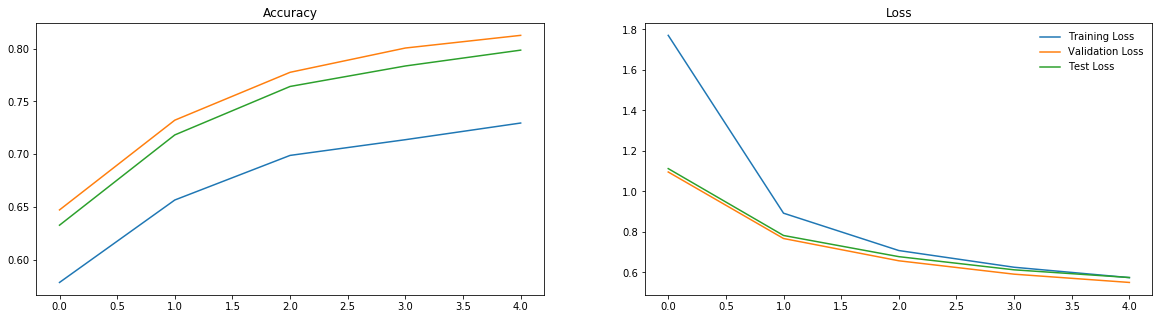

In [8]:
# if __name__=='__main__':
run()

## QUESTION

When you train a deep neural net, then you
get after every epoch one model (actually after every minibatch). Why
you should not select the best model over all epochs on the test dataset?

Answer:
It is possible that the best model selected could have an overfit as compared to the other models from other epochs. 

In [3]:
tr_data = datasets.FashionMNIST("FashionMNIST_data", train = True, download = True, transform = transforms.ToTensor())
tr_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: FashionMNIST_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [11]:
trloader = torch.utils.data.DataLoader(tr_data, batch_size = 100, shuffle=True)


In [40]:
# for idx, data in enumerate(trloader):
#     print(data[].shape)
#     if idx == 10:
#         break
trloader.dataset.data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,